## DataLoader & DeepPurpose Demo

[Tianfan](futianfan.github.io)




### DataLoader

Supposed a dataset X is from therapeutic task Y with machine learning problem Z, then to obtain the data and splits, simply type:



```python
from tdc.Z import Y
data = Y(name = 'X')
split = data.split()
```

Z can be 
- `single_pred`
- `multi_pred`
- `generation`

The circle can be small molecule, protein. 

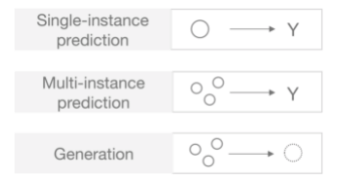

#### `single_pred`: Prediction of property for an individual biomedical entity.

In [12]:
from tdc.single_pred import ADME
data = ADME(name = 'Caco2_Wang', convert_format = 'DGL')

Found local copy...
Loading...
Done!


#### `multi_pred`: Prediction of property for multiple biomedical entities.

In [13]:
from tdc.multi_pred import PPI
data = PPI(name = 'HuRI')
split = data.get_split()
split['valid'].head(2)

Found local copy...
Loading...
Done!


,Protein1_ID,Protein1,Protein2_ID,Protein2,Y
0,ENSG00000102119,MDNYADLSDTELTTLLRRYNIPHGPVVDLNSTRGDADMYDLPKKED...,ENSG00000176435,MRPAFALCLLWQALWPGPGGGEHPTADRAGCSASGACYSLHHATMK...,1
1,ENSG00000157110,MNNGGKAEKENTPSEANLQEEEVRTLFVSGLPLDIKPRELYLLFRP...,ENSG00000227151,MEEPRPSKRLRSMAPNQASGGPPPEPGCCVADPEGSVEADGPAQPA...,1


#### `generation`: Generation of a new desirable biomedical entity.

In [14]:
from tdc.generation import MolGen
data = MolGen(name = 'MOSES')
split = data.get_split()
split['train'].head(2)

Found local copy...
Loading...
Done!


,smiles
0,CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1
1,CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1ccnc1


In [15]:
from tdc.generation import RetroSyn
data = RetroSyn(name = 'USPTO-50K')
split = data.get_split()
split['train'].head(2)

Found local copy...
Loading...
Done!


,input,output
0,COC(=O)CCC(=O)c1ccc(OC2CCCCO2)cc1O,C1=COCCC1.COC(=O)CCC(=O)c1ccc(O)cc1O
1,COC(=O)c1cccc(-c2nc3cccnc3[nH]2)c1,COC(=O)c1cccc(C(=O)O)c1.Nc1cccnc1N




### ML-ready example: DeepPurpose Overview
DeepPurpose is a scikit learn style Deep Learning Based Molecular Modeling and Prediction Toolkit on Drug-Target Interaction Prediction, Compound Property Prediction, Protein-Protein Interaction Prediction, and Protein Function prediction. Using DeepPurpose, we can rapidly build model prototypes for various drug discovery tasks covered in TDC, such as ADME, Tox, HTS, Developability prediction, DTI, DDI, PPI, Antibody Affinity predictions. 

Note that DeepPurpose is developed by two of the core teams in TDC, Kexin and Tianfan, and it is now published in Bioinformatics. To start with this tutorial, please follow [DeepPurpose instructions](https://github.com/kexinhuang12345/DeepPurpose#install--usage) to set up the necessary packages. DeepPurpose also provides [tutorials](https://github.com/kexinhuang12345/DeepPurpose/blob/master/Tutorial_1_DTI_Prediction.ipynb) for you to familiarize with it. 

### DeepPurpose Installation

```bash
conda create -n DeepPurpose python=3.6
conda activate DeepPurpose
conda install -c conda-forge rdkit
pip install git+https://github.com/bp-kelley/descriptastorus 
pip install DeepPurpose
pip install PyTDC --upgrade
```


We assume now you have set up the right environment. Now, we show you how to build an ADME predictor using Message Passing Neural Network (MPNN)! 

### Predicting HIA using MPNN with 10 Lines of Code

First, let's load DeepPurpose and TDC:

In [26]:
from DeepPurpose import utils, CompoundPred
from tdc.single_pred import ADME

Now, you can get the HIA dataset from TDC. HIA is from ADME task from Single-instance prediction and we want to predict whether or not can a compound be absorped in human intestinal, i.e. given SMILES X, predict 1/0. Note that for drug property prediction, DeepPurpose takes in an array of drug SMILES string and an array of labels. You could access that directly by setting the `get_data(format = 'dict')`:

In [27]:
data = ADME(name = 'HIA_Hou', convert_format='DGL').get_data(format = 'dict')
X, y = data['Drug'], data['Y']

Found local copy...
Loading...
Done!


or for simplicity. We also provide a DeepPurpose format, where you can directly get the correct input data:

In [28]:
X, y = ADME(name = 'HIA_Hou', convert_format = 'DGL').get_data(format = 'DeepPurpose')

Found local copy...
Loading...
Done!


DeepPurpose provides 8 encoders for compound, ranging from MLP on classic cheminformatics fingerprint such as Morgan, RDKit2D to deep learning models such as CNN, transformer, and MPNN. To specify the encoder, simply types the encoder name. Here, we use MPNN as an example:

Now, we encode the data into the specified format, using `utils.data_process` function. It specifies train/validation/test split fractions, and random seed to ensure same data splits for reproducibility. **We have made DeepPurpose to accomodate the TDC benchmark split.** Simply type 'TDC' in the random seed will generate the same split as in TDC split function. The function outputs train, val, test pandas dataframes.

In [29]:
drug_encoding = 'MPNN'
train, val, test = utils.data_process(X_drug = X, 
                                      y = y, 
                                      drug_encoding = drug_encoding,
                                      random_seed = 'TDC')

Drug Property Prediction Mode...
in total: 578 drugs
encoding drug...
unique drugs: 578
Done.


In [21]:
train.head(2)

,SMILES,Label,drug_encoding
0,CC(=O)Nc1ccccc1,1,"[[[tensor(1.), tensor(0.), tensor(0.), tensor(..."
1,CC(=O)Nc1nnc(S(N)(=O)=O)s1,1,"[[[tensor(1.), tensor(0.), tensor(0.), tensor(..."


Build and train model within 4 lines of code, in less than 1 minute. 

In [30]:
config = utils.generate_config(drug_encoding = drug_encoding, 
                               train_epoch = 3, 
                               LR = 0.001, 
                               batch_size = 128,
                               mpnn_hidden_size = 32,
                               mpnn_depth = 2)
model = CompoundPred.model_initialize(**config)
model.train(train, val, test)
model.save_model('./tutorial_model')

Now, you need to initialize the model. You can also load from pretrained model by `CompoundPred.model_pretrained(path_dir = PATH)`. Here, we initialize a new model:

Found local copy...
Loading...
Done!


Drug Property Prediction Mode...
in total: 4200 drugs
encoding drug...
unique drugs: 4200
Done.
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 5.90903. Total time 0.0 hours
Validation at Epoch 1 , MSE: 1.41579 , Pearson Correlation: 0.37311 with p-value: 2.54608 , Concordance Index: 0.64290
Training at Epoch 2 iteration 0 with loss 1.52792. Total time 0.00055 hours
Validation at Epoch 2 , MSE: 1.22507 , Pearson Correlation: 0.50885 with p-value: 4.79928 , Concordance Index: 0.68076
Training at Epoch 3 iteration 0 with loss 1.15630. Total time 0.00138 hours
Validation at Epoch 3 , MSE: 0.84279 , Pearson Correlation: 0.65883 with p-value: 1.25813 , Concordance Index: 0.73375
Training at Epoch 4 iteration 0 with loss 0.51819. Total time 0.00222 hours
Validation at Epoch 4 , MSE: 0.75855 , Pearson Correlation: 0.70421 with p-value: 3.68311 , Concordance Index: 0.75331
Training at Epoch 5 iteration 0 with loss 0.33011. Total time 

Found local copy...
Loading...
Done!
RDKit WARNING: [11:52:39] WARNING: not removing hydrogen atom without neighbors


Drug Property Prediction Mode...
in total: 9982 drugs
encoding drug...
unique drugs: 9982


RDKit WARNING: [11:52:39] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:52:39] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:52:39] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:52:39] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:52:40] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:52:40] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:52:40] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:52:40] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:52:40] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:52:40] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:52:40] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:52:40] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:52:40] WARNING: not r

Done.
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 15.5877. Total time 0.0 hours
Validation at Epoch 1 , MSE: 2.88394 , Pearson Correlation: 0.74493 with p-value: 2.79317 , Concordance Index: 0.77344
Training at Epoch 2 iteration 0 with loss 2.05276. Total time 0.00166 hours
Validation at Epoch 2 , MSE: 1.86287 , Pearson Correlation: 0.81162 with p-value: 9.42479 , Concordance Index: 0.80429
Training at Epoch 3 iteration 0 with loss 1.26623. Total time 0.00361 hours
Validation at Epoch 3 , MSE: 1.63036 , Pearson Correlation: 0.83546 with p-value: 3.35991 , Concordance Index: 0.81997
Training at Epoch 4 iteration 0 with loss 0.43174. Total time 0.00555 hours
Validation at Epoch 4 , MSE: 1.63094 , Pearson Correlation: 0.84401 with p-value: 9.69951 , Concordance Index: 0.82573
Training at Epoch 5 iteration 0 with loss 0.72359. Total time 0.00722 hours
Validation at Epoch 5 , MSE: 1.50493 , Pearson Correlation: 0.85094 with p-v

Found local copy...
Loading...
Done!


Drug Property Prediction Mode...
in total: 642 drugs
encoding drug...
unique drugs: 642
Done.
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 23.5426. Total time 0.0 hours
Validation at Epoch 1 , MSE: 26.8948 , Pearson Correlation: 0.36681 with p-value: 0.00287 , Concordance Index: 0.61712
Training at Epoch 2 iteration 0 with loss 16.4240. Total time 0.0 hours
Validation at Epoch 2 , MSE: 11.6538 , Pearson Correlation: 0.54223 with p-value: 3.69227 , Concordance Index: 0.68362
Training at Epoch 3 iteration 0 with loss 11.9912. Total time 0.00027 hours
Validation at Epoch 3 , MSE: 13.4426 , Pearson Correlation: 0.67749 with p-value: 7.84624 , Concordance Index: 0.74615
Training at Epoch 4 iteration 0 with loss 8.60779. Total time 0.00027 hours
Validation at Epoch 4 , MSE: 7.15313 , Pearson Correlation: 0.71875 with p-value: 2.26142 , Concordance Index: 0.76997
Training at Epoch 5 iteration 0 with loss 5.00369. Total time 0.0005

Found local copy...
Loading...
Done!


Drug Property Prediction Mode...
in total: 910 drugs
encoding drug...
unique drugs: 906
Done.
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 27.6825. Total time 0.0 hours
Validation at Epoch 1 , MSE: 1.19345 , Pearson Correlation: 0.28202 with p-value: 0.00676 , Concordance Index: 0.58139
Training at Epoch 2 iteration 0 with loss 1.15736. Total time 0.0 hours
Validation at Epoch 2 , MSE: 6.71028 , Pearson Correlation: 0.41273 with p-value: 4.79113 , Concordance Index: 0.62208
Training at Epoch 3 iteration 0 with loss 6.21552. Total time 0.00027 hours
Validation at Epoch 3 , MSE: 0.47933 , Pearson Correlation: 0.49117 with p-value: 7.67586 , Concordance Index: 0.67087
Training at Epoch 4 iteration 0 with loss 0.38179. Total time 0.00027 hours
Validation at Epoch 4 , MSE: 0.44025 , Pearson Correlation: 0.53784 with p-value: 3.84546 , Concordance Index: 0.68582
Training at Epoch 5 iteration 0 with loss 0.36843. Total time 0.0005

Found local copy...
Loading...
Done!


Drug Property Prediction Mode...
in total: 578 drugs
encoding drug...
unique drugs: 578
Done.
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.69091. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.59103 , AUPRC: 0.90914 , F1: 0.93577
Training at Epoch 2 iteration 0 with loss 0.38046. Total time 0.0 hours
Validation at Epoch 2 , AUROC: 0.77310 , AUPRC: 0.96125 , F1: 0.93577
Training at Epoch 3 iteration 0 with loss 0.47578. Total time 0.00027 hours
Validation at Epoch 3 , AUROC: 0.81512 , AUPRC: 0.96938 , F1: 0.93577
Training at Epoch 4 iteration 0 with loss 0.36816. Total time 0.00027 hours
Validation at Epoch 4 , AUROC: 0.81512 , AUPRC: 0.96989 , F1: 0.93577
Training at Epoch 5 iteration 0 with loss 0.26490. Total time 0.00027 hours
Validation at Epoch 5 , AUROC: 0.80392 , AUPRC: 0.96649 , F1: 0.93577
--- Go for Testing ---
Testing AUROC: 0.8554455445544554 , AUPRC: 0.9718182388272016 , F1: 0.9308755760368664
--- Trai

Found local copy...
Loading...
Done!


Drug Property Prediction Mode...
in total: 1218 drugs
encoding drug...
unique drugs: 1212
Done.
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.69268. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.86722 , AUPRC: 0.92053 , F1: 0.74226
Training at Epoch 2 iteration 0 with loss 0.55338. Total time 0.00027 hours
Validation at Epoch 2 , AUROC: 0.74055 , AUPRC: 0.86822 , F1: 0.76923
Training at Epoch 3 iteration 0 with loss 0.41887. Total time 0.00027 hours
Validation at Epoch 3 , AUROC: 0.92555 , AUPRC: 0.95890 , F1: 0.84444
Training at Epoch 4 iteration 0 with loss 0.15789. Total time 0.00055 hours
Validation at Epoch 4 , AUROC: 0.93944 , AUPRC: 0.96686 , F1: 0.87769
Training at Epoch 5 iteration 0 with loss 0.14575. Total time 0.00083 hours
Validation at Epoch 5 , AUROC: 0.93416 , AUPRC: 0.96338 , F1: 0.87417
--- Go for Testing ---
Testing AUROC: 0.9208333333333334 , AUPRC: 0.9396058214113587 , F1: 0.8653061224489798
--

Found local copy...
Loading...
Done!


Drug Property Prediction Mode...
in total: 640 drugs
encoding drug...
unique drugs: 640
Done.
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.68636. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.55374 , AUPRC: 0.82469 , F1: 0.86725
Training at Epoch 2 iteration 0 with loss 0.54784. Total time 0.0 hours
Validation at Epoch 2 , AUROC: 0.73061 , AUPRC: 0.88931 , F1: 0.86725
Training at Epoch 3 iteration 0 with loss 0.52629. Total time 0.00027 hours
Validation at Epoch 3 , AUROC: 0.73877 , AUPRC: 0.90023 , F1: 0.86725
Training at Epoch 4 iteration 0 with loss 0.57089. Total time 0.00027 hours
Validation at Epoch 4 , AUROC: 0.74829 , AUPRC: 0.90443 , F1: 0.86725
Training at Epoch 5 iteration 0 with loss 0.53500. Total time 0.00055 hours
Validation at Epoch 5 , AUROC: 0.75510 , AUPRC: 0.90969 , F1: 0.86725
--- Go for Testing ---
Testing AUROC: 0.6981132075471699 , AUPRC: 0.9118915686711747 , F1: 0.905982905982906
--- Train

Found local copy...
Loading...
Done!


Drug Property Prediction Mode...
in total: 1130 drugs
encoding drug...
unique drugs: 1111
Done.
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 3947.78. Total time 0.0 hours
Validation at Epoch 1 , MSE: 25.2327 , Pearson Correlation: 0.31796 with p-value: 0.00059 , Concordance Index: 0.57532
Training at Epoch 2 iteration 0 with loss 43.1675. Total time 0.00027 hours
Validation at Epoch 2 , MSE: 20.2340 , Pearson Correlation: 0.50347 with p-value: 1.31610 , Concordance Index: 0.70179
Training at Epoch 3 iteration 0 with loss 174.218. Total time 0.00027 hours
Validation at Epoch 3 , MSE: 27.1888 , Pearson Correlation: 0.52019 with p-value: 3.52286 , Concordance Index: 0.72438
Training at Epoch 4 iteration 0 with loss 49.7871. Total time 0.00055 hours
Validation at Epoch 4 , MSE: 27.9079 , Pearson Correlation: 0.45143 with p-value: 5.20720 , Concordance Index: 0.72391
Training at Epoch 5 iteration 0 with loss 29.4060. Total time 

Found local copy...
Loading...
Done!


Drug Property Prediction Mode...
in total: 12665 drugs
encoding drug...
unique drugs: 12665
Done.
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.69315. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.85831 , AUPRC: 0.82900 , F1: 0.76959
Training at Epoch 2 iteration 0 with loss 0.41192. Total time 0.00222 hours
Validation at Epoch 2 , AUROC: 0.86138 , AUPRC: 0.83598 , F1: 0.78013
Training at Epoch 3 iteration 0 with loss 0.29112. Total time 0.00472 hours
Validation at Epoch 3 , AUROC: 0.86080 , AUPRC: 0.83186 , F1: 0.78588
Training at Epoch 4 iteration 0 with loss 0.12776. Total time 0.00722 hours
Validation at Epoch 4 , AUROC: 0.84874 , AUPRC: 0.81534 , F1: 0.76710
Training at Epoch 5 iteration 0 with loss 0.08446. Total time 0.00972 hours
Validation at Epoch 5 , AUROC: 0.83640 , AUPRC: 0.81061 , F1: 0.75675
--- Go for Testing ---
Testing AUROC: 0.8708743768631085 , AUPRC: 0.826356941297399 , F1: 0.7703513281919451
-

Found local copy...
Loading...
Done!


Drug Property Prediction Mode...
in total: 13130 drugs
encoding drug...
unique drugs: 13130
Done.
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.68747. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.79295 , AUPRC: 0.55778 , F1: 0.45251
Training at Epoch 2 iteration 0 with loss 0.31054. Total time 0.00222 hours
Validation at Epoch 2 , AUROC: 0.81633 , AUPRC: 0.57601 , F1: 0.53393
Training at Epoch 3 iteration 0 with loss 0.18249. Total time 0.00472 hours
Validation at Epoch 3 , AUROC: 0.80012 , AUPRC: 0.55655 , F1: 0.50666
Training at Epoch 4 iteration 0 with loss 0.12316. Total time 0.00722 hours
Validation at Epoch 4 , AUROC: 0.81148 , AUPRC: 0.55862 , F1: 0.50112
Training at Epoch 5 iteration 0 with loss 0.07584. Total time 0.00944 hours
Validation at Epoch 5 , AUROC: 0.80723 , AUPRC: 0.57244 , F1: 0.49400
--- Go for Testing ---
Testing AUROC: 0.8453736467335302 , AUPRC: 0.6764851123742811 , F1: 0.6003898635477583


Found local copy...
Loading...
Done!


Drug Property Prediction Mode...
in total: 12328 drugs
encoding drug...
unique drugs: 12328
Done.
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.69248. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.85884 , AUPRC: 0.82051 , F1: 0.73581
Training at Epoch 2 iteration 0 with loss 0.41407. Total time 0.00222 hours
Validation at Epoch 2 , AUROC: 0.88375 , AUPRC: 0.85861 , F1: 0.77074
Training at Epoch 3 iteration 0 with loss 0.20424. Total time 0.00444 hours
Validation at Epoch 3 , AUROC: 0.86710 , AUPRC: 0.84144 , F1: 0.74215
Training at Epoch 4 iteration 0 with loss 0.11601. Total time 0.00638 hours
Validation at Epoch 4 , AUROC: 0.87853 , AUPRC: 0.85237 , F1: 0.76102
Training at Epoch 5 iteration 0 with loss 0.04398. Total time 0.00861 hours
Validation at Epoch 5 , AUROC: 0.87259 , AUPRC: 0.84827 , F1: 0.74224
--- Go for Testing ---
Testing AUROC: 0.8796599479320433 , AUPRC: 0.8481695438752704 , F1: 0.7776286353467561


Found local copy...
Loading...
Done!


Drug Property Prediction Mode...
in total: 12579 drugs
encoding drug...
unique drugs: 12579
Done.
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.69368. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.90001 , AUPRC: 0.88533 , F1: 0.80854
Training at Epoch 2 iteration 0 with loss 0.30478. Total time 0.00222 hours
Validation at Epoch 2 , AUROC: 0.91278 , AUPRC: 0.90684 , F1: 0.80583
Training at Epoch 3 iteration 0 with loss 0.16535. Total time 0.00472 hours
Validation at Epoch 3 , AUROC: 0.90588 , AUPRC: 0.89928 , F1: 0.80524
Training at Epoch 4 iteration 0 with loss 0.09002. Total time 0.00694 hours
Validation at Epoch 4 , AUROC: 0.90421 , AUPRC: 0.89388 , F1: 0.82110
Training at Epoch 5 iteration 0 with loss 0.07560. Total time 0.00944 hours
Validation at Epoch 5 , AUROC: 0.90728 , AUPRC: 0.89880 , F1: 0.82161
--- Go for Testing ---
Testing AUROC: 0.8824296671295863 , AUPRC: 0.8722500643261843 , F1: 0.7734410049349485


Downloading...
100%|██████████| 740k/740k [00:01<00:00, 439kiB/s] 
Loading...
Done!


Drug Property Prediction Mode...
in total: 12092 drugs
encoding drug...
unique drugs: 12092
Done.
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.69969. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.85434 , AUPRC: 0.72014 , F1: 0.68409
Training at Epoch 2 iteration 0 with loss 0.49054. Total time 0.00194 hours
Validation at Epoch 2 , AUROC: 0.87117 , AUPRC: 0.73898 , F1: 0.72082
Training at Epoch 3 iteration 0 with loss 0.29819. Total time 0.005 hours
Validation at Epoch 3 , AUROC: 0.87410 , AUPRC: 0.74778 , F1: 0.70324
Training at Epoch 4 iteration 0 with loss 0.11092. Total time 0.0075 hours
Validation at Epoch 4 , AUROC: 0.86696 , AUPRC: 0.74451 , F1: 0.68897
Training at Epoch 5 iteration 0 with loss 0.08073. Total time 0.00972 hours
Validation at Epoch 5 , AUROC: 0.86758 , AUPRC: 0.75186 , F1: 0.70388
--- Go for Testing ---
Testing AUROC: 0.867069523892246 , AUPRC: 0.7685155395085637 , F1: 0.7070457354758962
--- 

Downloading...
100%|██████████| 45.6k/45.6k [00:00<00:00, 1.70MiB/s]
Loading...
Done!


Drug Property Prediction Mode...
in total: 669 drugs
encoding drug...
unique drugs: 666
Done.
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.68925. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.52179 , AUPRC: 0.24969 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.47461. Total time 0.0 hours
Validation at Epoch 2 , AUROC: 0.58717 , AUPRC: 0.27934 , F1: 0.0
Training at Epoch 3 iteration 0 with loss 0.52962. Total time 0.0 hours
Validation at Epoch 3 , AUROC: 0.59743 , AUPRC: 0.28544 , F1: 0.0
Training at Epoch 4 iteration 0 with loss 0.43987. Total time 0.00027 hours
Validation at Epoch 4 , AUROC: 0.59615 , AUPRC: 0.29071 , F1: 0.0
Training at Epoch 5 iteration 0 with loss 0.37587. Total time 0.00027 hours
Validation at Epoch 5 , AUROC: 0.59871 , AUPRC: 0.29042 , F1: 0.0
--- Go for Testing ---
Testing AUROC: 0.6178608515057114 , AUPRC: 0.3441341212947574 , F1: 0.0
--- Training Finished ---


Downloading...
100%|██████████| 45.4k/45.4k [00:01<00:00, 39.6kiB/s]
Loading...
Done!


Drug Property Prediction Mode...
in total: 667 drugs
encoding drug...
unique drugs: 664
Done.
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.70148. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.63354 , AUPRC: 0.43380 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.59671. Total time 0.0 hours
Validation at Epoch 2 , AUROC: 0.76086 , AUPRC: 0.61636 , F1: 0.0
Training at Epoch 3 iteration 0 with loss 0.56336. Total time 0.00027 hours
Validation at Epoch 3 , AUROC: 0.77018 , AUPRC: 0.64350 , F1: 0.0
Training at Epoch 4 iteration 0 with loss 0.34480. Total time 0.00027 hours
Validation at Epoch 4 , AUROC: 0.79813 , AUPRC: 0.70107 , F1: 0.0
Training at Epoch 5 iteration 0 with loss 0.30903. Total time 0.00027 hours
Validation at Epoch 5 , AUROC: 0.76397 , AUPRC: 0.66185 , F1: 0.0
--- Go for Testing ---
Testing AUROC: 0.7875 , AUPRC: 0.6836921856577965 , F1: 0.0
--- Training Finished ---


Downloading...
100%|██████████| 46.0k/46.0k [00:01<00:00, 41.7kiB/s]
Loading...
Done!


Drug Property Prediction Mode...
in total: 670 drugs
encoding drug...
unique drugs: 667
Done.
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.69551. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.63709 , AUPRC: 0.62023 , F1: 0.63265
Training at Epoch 2 iteration 0 with loss 0.70291. Total time 0.0 hours
Validation at Epoch 2 , AUROC: 0.62724 , AUPRC: 0.60592 , F1: 0.63265
Training at Epoch 3 iteration 0 with loss 0.65236. Total time 0.0 hours
Validation at Epoch 3 , AUROC: 0.63978 , AUPRC: 0.63554 , F1: 0.63265
Training at Epoch 4 iteration 0 with loss 0.55061. Total time 0.00027 hours
Validation at Epoch 4 , AUROC: 0.66487 , AUPRC: 0.66110 , F1: 0.61764
Training at Epoch 5 iteration 0 with loss 0.39404. Total time 0.00027 hours
Validation at Epoch 5 , AUROC: 0.66442 , AUPRC: 0.66122 , F1: 0.61176
--- Go for Testing ---
Testing AUROC: 0.6951871657754012 , AUPRC: 0.6480300131326664 , F1: 0.6474820143884891
--- Training

Downloading...
100%|██████████| 138k/138k [00:01<00:00, 97.8kiB/s]
Loading...
Done!
RDKit WARNING: [11:58:46] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:58:46] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:58:46] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:58:46] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:58:46] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:58:46] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:58:46] WARNING: not removing hydrogen atom without neighbors


Drug Property Prediction Mode...
in total: 2030 drugs
encoding drug...
unique drugs: 1975


RDKit WARNING: [11:58:46] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:58:46] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:58:46] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:58:46] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:58:47] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:58:47] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:58:47] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:58:47] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:58:47] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:58:47] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:58:47] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:58:47] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:58:47] WARNING: not r

Done.
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.70210. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.87137 , AUPRC: 0.95259 , F1: 0.86592
Training at Epoch 2 iteration 0 with loss 0.51447. Total time 0.00027 hours
Validation at Epoch 2 , AUROC: 0.91424 , AUPRC: 0.96753 , F1: 0.86592
Training at Epoch 3 iteration 0 with loss 0.32830. Total time 0.00055 hours
Validation at Epoch 3 , AUROC: 0.91841 , AUPRC: 0.97024 , F1: 0.91205
Training at Epoch 4 iteration 0 with loss 0.16257. Total time 0.00083 hours
Validation at Epoch 4 , AUROC: 0.91048 , AUPRC: 0.96784 , F1: 0.92834
Training at Epoch 5 iteration 0 with loss 0.09300. Total time 0.00138 hours
Validation at Epoch 5 , AUROC: 0.90026 , AUPRC: 0.96532 , F1: 0.90384
--- Go for Testing ---
Testing AUROC: 0.8515221878224974 , AUPRC: 0.9242517678035056 , F1: 0.897226753670473
--- Training Finished ---


Downloading...
100%|██████████| 214k/214k [00:00<00:00, 2.80MiB/s]
Loading...
Done!


Drug Property Prediction Mode...
in total: 2790 drugs
encoding drug...
unique drugs: 1797
Done.
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 7625.08. Total time 0.0 hours
Validation at Epoch 1 , MSE: 1254.30 , Pearson Correlation: 0.32314 with p-value: 3.34856 , Concordance Index: 0.57641
Training at Epoch 2 iteration 0 with loss 1216.75. Total time 0.00027 hours
Validation at Epoch 2 , MSE: 315.088 , Pearson Correlation: 0.51325 with p-value: 3.75916 , Concordance Index: 0.65970
Training at Epoch 3 iteration 0 with loss 364.828. Total time 0.00083 hours
Validation at Epoch 3 , MSE: 224.695 , Pearson Correlation: 0.63706 with p-value: 3.61616 , Concordance Index: 0.71135
Training at Epoch 4 iteration 0 with loss 228.636. Total time 0.00138 hours
Validation at Epoch 4 , MSE: 231.617 , Pearson Correlation: 0.70029 with p-value: 1.92002 , Concordance Index: 0.73068
Training at Epoch 5 iteration 0 with loss 147.830. Total time 

Downloading...
100%|██████████| 53.6k/53.6k [00:00<00:00, 1.70MiB/s]
Loading...
Done!


Drug Property Prediction Mode...
in total: 667 drugs
encoding drug...
unique drugs: 665
Done.
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 567.930. Total time 0.0 hours
Validation at Epoch 1 , MSE: 561.249 , Pearson Correlation: 0.25670 with p-value: 0.03599 , Concordance Index: 0.47490
Training at Epoch 2 iteration 0 with loss 5711.53. Total time 0.0 hours
Validation at Epoch 2 , MSE: 491.178 , Pearson Correlation: 0.27104 with p-value: 0.02651 , Concordance Index: 0.49087
Training at Epoch 3 iteration 0 with loss 5595.78. Total time 0.0 hours
Validation at Epoch 3 , MSE: 452.711 , Pearson Correlation: 0.29795 with p-value: 0.01433 , Concordance Index: 0.56706
Training at Epoch 4 iteration 0 with loss 7487.57. Total time 0.00027 hours
Validation at Epoch 4 , MSE: 607.645 , Pearson Correlation: 0.18558 with p-value: 0.13269 , Concordance Index: 0.61815
Training at Epoch 5 iteration 0 with loss 3692.16. Total time 0.00027 ho

Downloading...
100%|██████████| 91.6k/91.6k [00:01<00:00, 60.5kiB/s]
Loading...
Done!


Drug Property Prediction Mode...
in total: 1213 drugs
encoding drug...
unique drugs: 1020
Done.
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 4556.68. Total time 0.0 hours
Validation at Epoch 1 , MSE: 2542.56 , Pearson Correlation: -0.1479 with p-value: 0.10545 , Concordance Index: 0.45186
Training at Epoch 2 iteration 0 with loss 3147.03. Total time 0.0 hours
Validation at Epoch 2 , MSE: 2431.79 , Pearson Correlation: 0.01996 with p-value: 0.82797 , Concordance Index: 0.51531
Training at Epoch 3 iteration 0 with loss 2735.28. Total time 0.00027 hours
Validation at Epoch 3 , MSE: 2240.46 , Pearson Correlation: 0.20326 with p-value: 0.02534 , Concordance Index: 0.58722
Training at Epoch 4 iteration 0 with loss 2210.22. Total time 0.00055 hours
Validation at Epoch 4 , MSE: 2448.70 , Pearson Correlation: 0.30698 with p-value: 0.00061 , Concordance Index: 0.62733
Training at Epoch 5 iteration 0 with loss 2074.55. Total time 0.00

Downloading...
100%|██████████| 81.7k/81.7k [00:01<00:00, 54.0kiB/s]
Loading...
Done!


Drug Property Prediction Mode...
in total: 1102 drugs
encoding drug...
unique drugs: 1102
Done.
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 2664.26. Total time 0.0 hours
Validation at Epoch 1 , MSE: 2348.95 , Pearson Correlation: 0.14874 with p-value: 0.12092 , Concordance Index: 0.56792
Training at Epoch 2 iteration 0 with loss 1995.89. Total time 0.00027 hours
Validation at Epoch 2 , MSE: 2038.06 , Pearson Correlation: 0.34638 with p-value: 0.00020 , Concordance Index: 0.69464
Training at Epoch 3 iteration 0 with loss 1615.50. Total time 0.00027 hours
Validation at Epoch 3 , MSE: 1809.44 , Pearson Correlation: 0.39875 with p-value: 1.59765 , Concordance Index: 0.72389
Training at Epoch 4 iteration 0 with loss 1257.21. Total time 0.00055 hours
Validation at Epoch 4 , MSE: 1741.09 , Pearson Correlation: 0.41307 with p-value: 7.29808 , Concordance Index: 0.73560
Training at Epoch 5 iteration 0 with loss 1247.47. Total time 

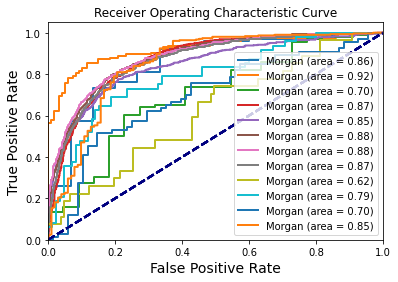

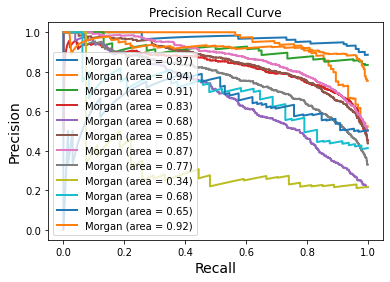

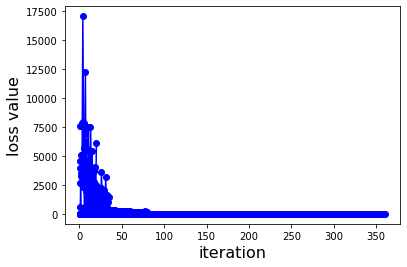

In [18]:
from tdc.utils import retrieve_dataset_names
adme_datasets = retrieve_dataset_names('ADME')

for dataset_name in adme_datasets:
    X, y = ADME(name = dataset_name).get_data(format = 'DeepPurpose')
    drug_encoding = 'Morgan'
    train, val, test = utils.data_process(X_drug = X, 
                                      y = y, 
                                      drug_encoding = drug_encoding,
                                      random_seed = 'TDC')
    config = utils.generate_config(drug_encoding = drug_encoding, 
                         train_epoch = 5, 
                         LR = 0.001, 
                         batch_size = 128,
                         mpnn_hidden_size = 32,
                         mpnn_depth = 2
                        )
    model = CompoundPred.model_initialize(**config)
    model.train(train, val, test)
    model.save_model('./' + dataset_name + '_model')

We have tested the above code and it would print out all the training process. We omit the output here since it is a bit long. But hopefully, you could get the gist of it. DeepPurpose also allows to do similar modeling for DTI, DDI, PPI and protein function prediction! Checkout the [repository](https://github.com/kexinhuang12345/DeepPurpose)!

That's it for this tutorial!